# MVG Rad

Let's explore the data MVG Rad data.




## Setup

### Imports

First, let's import the libraries that we need.

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from cartopy.io.img_tiles import OSM
from matplotlib.offsetbox import AnchoredText
from pyproj import Geod
from scipy import ndimage

### Parameters

The raw data contain a small amount of "bad" data, such invalid GPS coordinates.

To filtere these out, we define plausible ranges for valid data:

In [2]:
MIN_LAT = 48.0
MAX_LAT = 48.3
MIN_LON = 11.25
MAX_LON = 11.85

### Load the data

Before running this, make sure that you have downloaded the raw data to the `raw-data` folder.

In [3]:
# Some of the numeric columns in the CSV file contain trailing spaces,
# Polars is unable to parse them, see https://github.com/pola-rs/polars/issues/14530
# So we need to read them as strings first, and then strip the spaces:
unparsed_data = pl.scan_csv(
    "raw-data/MVG_Rad_Fahrten_*.csv",
    separator=";",
    with_column_names=lambda names: [name.strip() for name in names],
    try_parse_dates=True,
)

all_rides = unparsed_data.select(
    pl.col("STARTTIME").alias("start_time"),
    pl.col("ENDTIME").alias("end_time"),
    pl.col("STARTLAT")
    .str.strip_chars()
    .str.replace(",", ".")
    .cast(pl.Float32)
    .alias("start_lat"),
    pl.col("STARTLON")
    .str.strip_chars()
    .str.replace(",", ".")
    .cast(pl.Float32)
    .alias("start_lon"),
    pl.col("ENDLAT")
    .str.strip_chars()
    .str.replace(",", ".")
    .cast(pl.Float32)
    .alias("end_lat"),
    pl.col("ENDLON")
    .str.strip_chars()
    .str.replace(",", ".")
    .cast(pl.Float32)
    .alias("end_lon"),
    pl.col("RENTAL_STATION_NAME").str.strip_chars().alias("start_station"),
    pl.col("RETURN_STATION_NAME").str.strip_chars().alias("end_station"),
)

### Enhance the data

Calculate some additional columns such as year, month, weekday, and time, as well as trip distance and duration.
These will enable us later to filter and group the data efficiently.

In [4]:
geod = Geod(ellps="WGS84")
all_rides = all_rides.collect()
distances = [
    geod.line_length(lats=[start_lat, end_lat], lons=[start_lon, end_lon])
    for start_lat, end_lat, start_lon, end_lon in zip(
        all_rides["start_lat"],
        all_rides["end_lat"],
        all_rides["start_lon"],
        all_rides["end_lon"],
    )
]

In [5]:
all_rides = all_rides.with_columns(
    year=pl.col("start_time").dt.year(),
    weekday=pl.col("start_time").dt.weekday(),
    time=pl.col("start_time").dt.time(),
    month=pl.col("start_time").dt.month(),
    distance=pl.Series(distances),
    duration=pl.col("end_time") - pl.col("start_time"),
)

In addition, let's calculate the set of stations

In [6]:
def get_stations(prefix: str):
    return (
        all_rides.group_by(station=f"{prefix}_station")
        .agg(
            pl.first(f"{prefix}_lat").alias("lat"),
            pl.first(f"{prefix}_lon").alias("lon"),
            pl.min("start_time"),
            pl.max("end_time"),
        )
        .filter(
            pl.col("station") != "",
            pl.col("lat").is_between(MIN_LAT, MAX_LAT),
            pl.col("lon").is_between(MIN_LON, MAX_LON),
        )
    )

stations = (
    pl.concat([get_stations("start"),get_stations("end")])
    .sort(pl.col("station"))
    .group_by("station")
    .agg(
        pl.mean("lat"),
        pl.mean("lon"),
        pl.min("start_time"),
        pl.max("end_time"),
    )
).sort("station")

## Basic investigations

### Rides per year

Let's start with a simple question: how many rides were there per year?

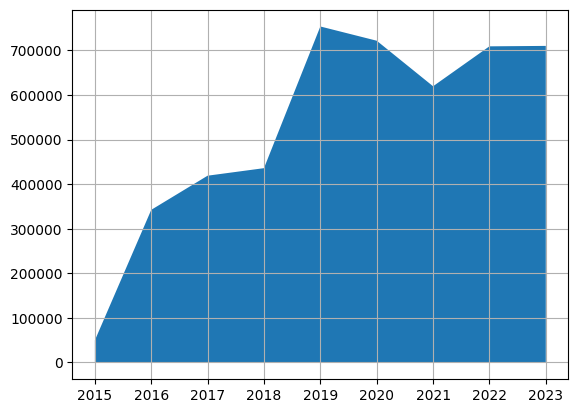

In [7]:
rides_by_year = (
    all_rides.select(pl.col("start_time").dt.year().alias("year"))
    .group_by("year")
    .agg(pl.len().alias("rides"))
    .sort("year")
)
fix, ax = plt.subplots()
ax.grid()
ax.fill_between(rides_by_year["year"], 0, rides_by_year["rides"])

In [8]:
all_rides.filter(pl.col("distance") > 50_000).describe()

statistic,start_time,end_time,start_lat,start_lon,end_lat,end_lon,start_station,end_station,year,weekday,time,month,distance,duration
str,str,str,f64,f64,f64,f64,str,str,f64,f64,str,f64,f64,str
"""count""","""116653""","""116653""",116653.0,116653.0,116653.0,116653.0,"""116653""","""116653""",116653.0,116653.0,"""116653""",116653.0,116653.0,"""116653"""
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,"""0""",0.0,0.0,"""0"""
"""mean""","""2019-06-26 05:17:21.168937""","""2019-06-26 06:33:22.776782""",27.624939,8.47699,21.142321,6.567921,null,null,2018.983001,3.964982,"""14:47:23.282898""",6.510248,5.4554e6,"""1:16:01.607845"""
"""std""",null,null,23.86562,10.023605,24.142258,10.303159,null,null,2.396017,1.91183,null,2.627572,818558.035713,null
"""min""","""2015-10-09 12:02:00""","""2015-10-09 12:26:00""",-55.973801,-122.698807,-55.973801,-122.698868,"""""","""""",2015.0,1.0,"""00:00:00""",1.0,50131.0156,"""0:00:00"""
"""25%""","""2017-05-16 22:38:00""","""2017-05-16 22:47:00""",0.0,0.0,0.0,0.0,null,null,2017.0,2.0,"""11:34:00""",5.0,5.4490e6,"""0:07:00"""
"""50%""","""2019-05-24 16:54:00""","""2019-05-24 17:13:00""",48.11895,11.54159,0.0,0.0,null,null,2019.0,4.0,"""15:37:00""",6.0,5.4507e6,"""0:12:00"""
"""75%""","""2021-06-26 14:51:00""","""2021-06-26 16:38:00""",48.150101,11.57634,48.143269,11.56818,null,null,2021.0,6.0,"""18:32:00""",8.0,5.4526e6,"""0:23:00"""
"""max""","""2023-12-31 14:44:00""","""2024-01-01 13:08:00""",53.592159,141.353226,65.591522,149.192184,"""nextbike Daniel Teststation - …","""nextbike Daniel Teststation - …",2023.0,7.0,"""23:59:00""",12.0,1.5204e7,"""69 days, 0:01:00"""


In [9]:

all_rides.filter(
    pl.col("start_lat").is_between(MIN_LAT, MAX_LAT),
    pl.col("start_lon").is_between(MIN_LON, MAX_LON),
    pl.col("end_lat").is_between(MIN_LAT, MAX_LAT),
    pl.col("end_lon").is_between(MIN_LON, MAX_LON),
).describe()

statistic,start_time,end_time,start_lat,start_lon,end_lat,end_lon,start_station,end_station,year,weekday,time,month,distance,duration
str,str,str,f64,f64,f64,f64,str,str,f64,f64,str,f64,f64,str
"""count""","""4632670""","""4632670""",4.63267e6,4.63267e6,4.63267e6,4.63267e6,"""4632670""","""4632670""",4.63267e6,4.63267e6,"""4632670""",4.63267e6,4.63267e6,"""4632670"""
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,"""0""",0.0,0.0,"""0"""
"""mean""","""2020-06-24 19:15:45.815160""","""2020-06-24 19:46:31.991940""",48.146069,11.567739,48.146221,11.567758,null,null,2019.955848,3.984857,"""14:43:49.412567""",6.814271,1872.52841,"""0:30:46.176779"""
"""std""",null,null,0.029039,0.037758,0.028975,0.037922,null,null,2.178179,1.946822,null,2.849409,1663.88274,null
"""min""","""2015-10-09 09:54:00""","""2015-10-09 10:25:00""",48.0,11.25067,48.0,11.25067,"""""","""""",2015.0,1.0,"""00:00:00""",1.0,0.0,"""-1 day, 23:03:00"""
"""25%""","""2018-11-09 19:21:00""","""2018-11-09 19:46:00""",48.12994,11.54865,48.13002,11.5487,null,null,2018.0,2.0,"""11:12:00""",5.0,754.241161,"""0:07:00"""
"""50%""","""2020-07-30 20:09:00""","""2020-07-30 20:36:00""",48.14592,11.56793,48.14592,11.56805,null,null,2020.0,4.0,"""15:41:00""",7.0,1434.193327,"""0:11:00"""
"""75%""","""2022-05-28 17:12:00""","""2022-05-28 17:47:00""",48.160568,11.58545,48.160648,11.58546,null,null,2022.0,6.0,"""18:40:00""",9.0,2525.552475,"""0:19:00"""
"""max""","""2023-12-31 23:54:00""","""2024-01-01 16:00:00""",48.299141,11.84742,48.299229,11.84742,"""astopark""","""recording_4158318""",2023.0,7.0,"""23:59:00""",12.0,30137.066601,"""144 days, 16:40:00"""


## Mapping

Now, lets draw some maps

### Basic heatmap

This is a heatmap of ride frequence (based on the start location), with stations indicated by red dots.

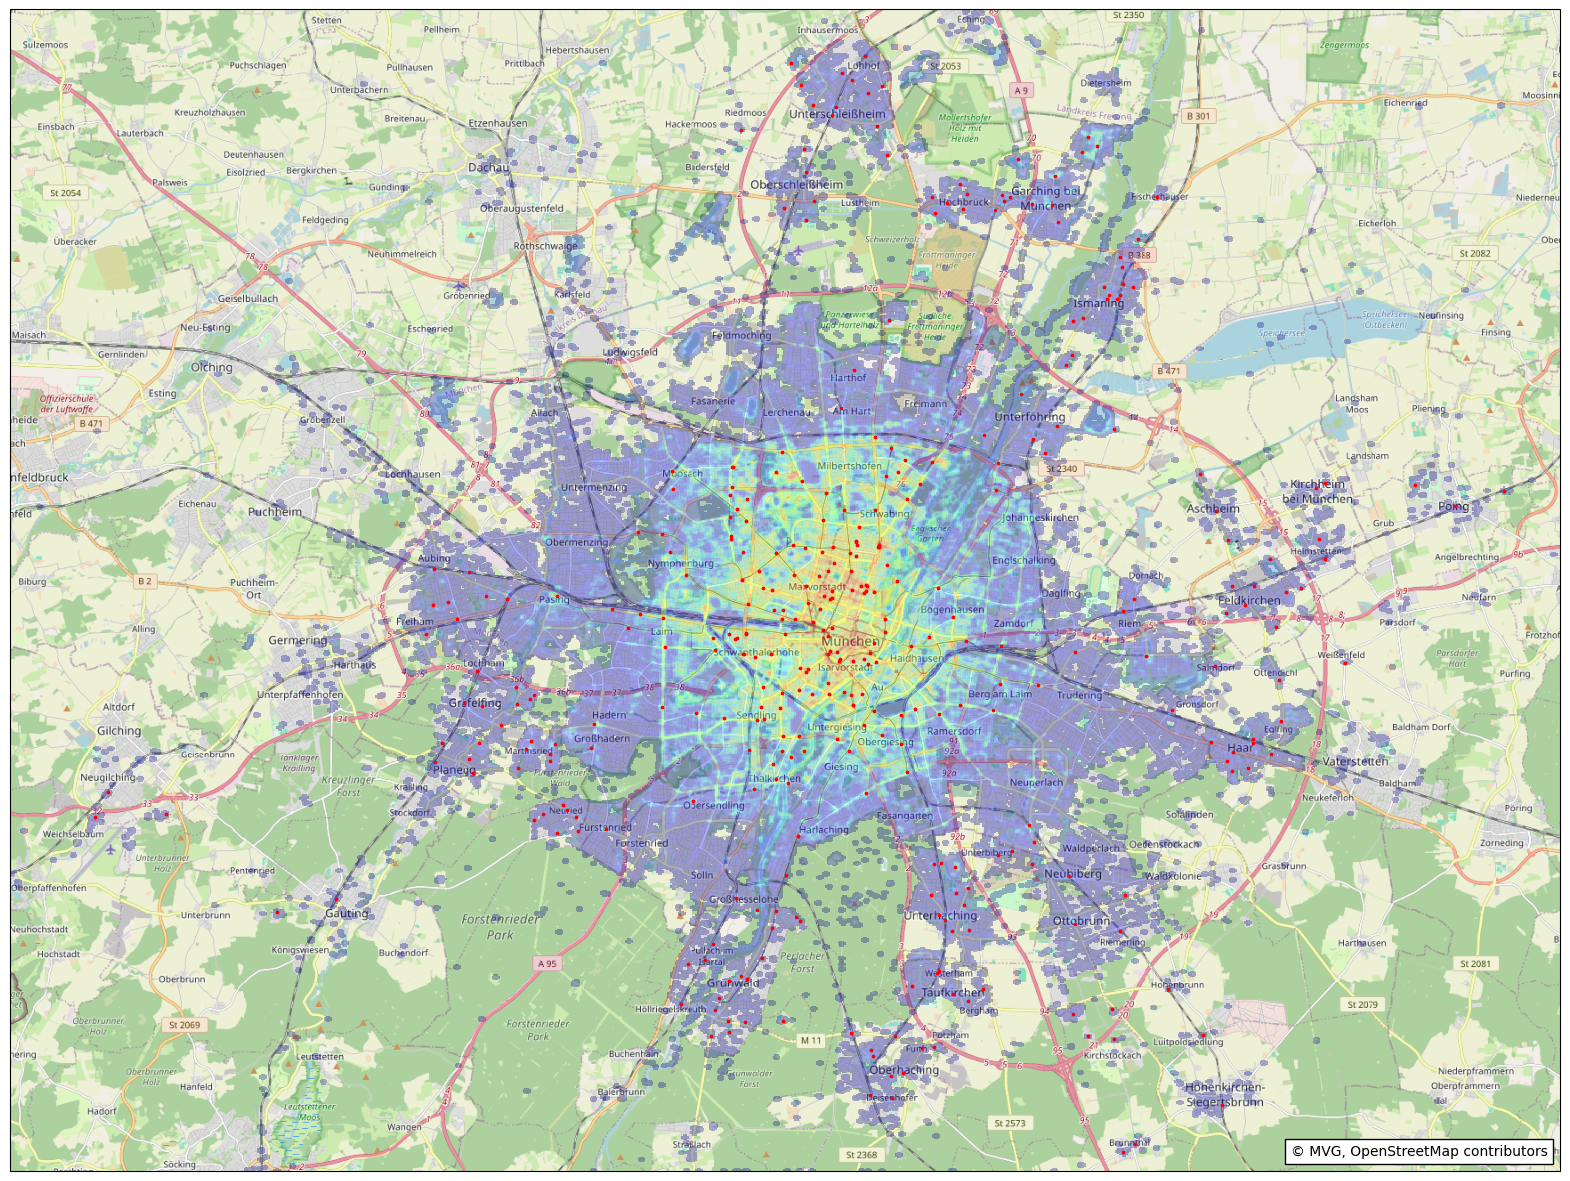

In [10]:
imagery = OSM(cache=True)

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=imagery.crs)
ax.set_extent([MIN_LON, MAX_LON, MIN_LAT, MAX_LAT], ccrs.PlateCarree())
ax.add_image(imagery, 12)
heatmap, _xedges, _yedges = np.histogram2d(
    all_rides["start_lon"],
    all_rides["start_lat"],
    bins=1000,
    range=((MIN_LON, MAX_LON), (MIN_LAT, MAX_LAT)),
)

logheatmap = np.arcsinh(heatmap)
logheatmap = ndimage.gaussian_filter(logheatmap, 1.0, mode="nearest")
lon = np.linspace(MIN_LON, MAX_LON, logheatmap.shape[0])
lat = np.linspace(MIN_LAT, MAX_LAT, logheatmap.shape[1])
logheatmap[logheatmap < 0.01] = None
Lat, Lon = np.meshgrid(lat, lon)
ax.pcolormesh(Lon, Lat, logheatmap, alpha=0.3, cmap="jet", transform=ccrs.PlateCarree())
ax.scatter(
    x=stations["lon"],
    y=stations["lat"],
    transform=ccrs.Geodetic(),
    s=3,
    c="red",
)
attribution = AnchoredText("© MVG, OpenStreetMap contributors", loc="lower right")
ax.add_artist(attribution)